In [1]:
import sys
sys.path.append("..")

import pandas as pd
from models import Yolov4
from tensorflow import keras
from config import yolo_config
from utils import DataGenerator, read_annotation_lines

import numpy as np
from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

import math
import torch
import xml.etree.ElementTree as ET
import os

# 使用第二張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
def get_iou(bbox_ai, bbox_gt):
    iou_x = max(bbox_ai[0], bbox_gt[0]) # x
    iou_y = max(bbox_ai[1], bbox_gt[1]) # y
    iou_w = min(bbox_ai[2]+bbox_ai[0], bbox_gt[2]+bbox_gt[0]) - iou_x # w
    iou_w = max(iou_w, 0)
    # print(f'{iou_w=}')
    iou_h = min(bbox_ai[3]+bbox_ai[1], bbox_gt[3]+bbox_gt[1]) - iou_y # h
    iou_h = max(iou_h, 0)
    # print(f'{iou_h=}')

    iou_area = iou_w * iou_h
    # print(f'{iou_area=}')
    all_area = bbox_ai[2]*bbox_ai[3] + bbox_gt[2]*bbox_gt[3] - iou_area
    # print(f'{all_area=}')

    if all_area == 0:  # 有可能雙方皆沒有重疊，或是一開始就沒有label
        return 0
    return max(iou_area/all_area, 0)

In [3]:
def calculate_ciou(box_1, box_2):
    """
    calculate ciou
    :param box_1: (x0, y0, x1, y1)
    :param box_2: (x0, y0, x1, y1)
    :return: value of ciou
    """
    # perfect
    if box_1==box_2:  
        return 1.0

    # calculate area of each box
    width_1 = box_1[2] - box_1[0]
    height_1 = box_1[3] - box_1[1]
    area_1 = width_1 * height_1

    width_2 = box_2[2] - box_2[0]
    height_2 = box_2[3] - box_2[1]
    area_2 = width_2 * height_2

    # calculate center point of each box
    center_x1 = (box_1[2] - box_1[0]) / 2
    center_y1 = (box_1[3] - box_1[1]) / 2
    center_x2 = (box_2[2] - box_2[0]) / 2
    center_y2 = (box_2[3] - box_2[1]) / 2

    # calculate square of center point distance
    p2 = (center_x2 - center_x1) ** 2 + (center_y2 - center_y1) ** 2

    # calculate square of the diagonal length
    width_c = max(box_1[2], box_2[2]) - min(box_1[0], box_2[0])
    height_c = max(box_1[3], box_2[3]) - min(box_1[1], box_2[1])
    c2 = width_c ** 2 + height_c ** 2

    # find the edge of intersect box
    left = max(box_1[0], box_2[0])
    top = max(box_1[1], box_2[1])
    bottom = min(box_1[3], box_2[3])
    right = min(box_1[2], box_2[2])

    # calculate the intersect area
    area_intersection = (right - left) * (bottom - top)

    # calculate the union area
    area_union = area_1 + area_2 - area_intersection

    # calculate iou
    iou = float(area_intersection) / area_union

    # calculate v
    arctan = math.atan(float(width_2) / height_2) - math.atan(float(width_1) / height_1)
    v = (4.0 / math.pi ** 2) * (arctan ** 2)

    # calculate alpha
    alpha = float(v) / (1 - iou + v)

    # calculate ciou(iou - p2 / c2 - alpha * v)
    ciou = iou - float(p2) / c2 - alpha * v

    return ciou

In [4]:
def plt_precision_recall_curve(y_true, y_scores):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    average_precision             = average_precision_score(y_true, y_scores)

    disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision)
    disp.plot()
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()
    # print('recall = ', recall)
    # print('thresholds = ', thresholds)
    print('AP={:.2f}'.format(average_precision))

# 載入模型

In [5]:
# yolo_config['score_threshold']=0.7
# print(yolo_config)

In [6]:
import warnings
warnings.filterwarnings('ignore')
class_name_path = '../class_names/classes.txt'
model = Yolov4(weight_path=None, class_name_path=class_name_path, config=yolo_config)
model.load_weights(path="../model/20220722_sopbox.weights")

nms iou: 0.2 score: 0.2


# 影片

In [7]:
# test_dir = 'test_i'
# test_img_paths = glob("../test_img/{}/*.png".format(test_dir))
# test_img_paths[0].split('\\')[1]


# '''
# output_img: image array
# detections: DataFram of box(x1,y1,x2,y2)
# '''
# pred_box_num = 0  # 有預測框的圖像數量
# for test_img_path in tqdm(test_img_paths):
#     test_img_no = test_img_path.split('\\')[1]
#     output_img, detections = model.predict(img_path=test_img_path, 
#                          random_color=False, # 框顏色
#                          plot_img=False, # 顯示出框選圖片
#                          show_text=True, # 框上面加上類別文字
#                          box_num=1,      # 顯示框的數量
#                          return_output=True)
#     if len(detections) == 1:
#         pred_box_num += 1
#     plt.imsave('../result_img/{}/test_{}'.format('test_i_big_box',test_img_no),output_img)

# print('有預測框的圖像數量=', pred_box_num)

# 每一個test 真實box數值

In [8]:
true_box_PATH = '../test_img/txt/anno_test_lines_0.txt'
true_bbox = {}
with open(true_box_PATH) as f:
    for line in f.readlines():
        true_bbox[line.split(' ')[0]] = tuple([int(i) for i in line.split(' ')[1].split(',')[:4]])

# 每一個預測的box數值

In [9]:
PATH = '../test_img/test_img_sopbox_0/'
pred_bbox = {}
for test_img_path in glob(os.path.join(PATH, '*.png')):
    test_img_name = test_img_path.split('\\')[1]
    output_img, detections = model.predict(img_path=test_img_path, 
                         random_color=False, # 框顏色
                         plot_img=False, # 顯示出框選圖片
                         show_text=True, # 框上面加上類別文字
                         box_num=1,      # 顯示框的數量
                         return_output=True)

    pred_box_num = len(detections['score'])
    if pred_box_num > 0:   # 有預測出box
        score = detections['score'].to_numpy()[0]
        if score > 0.5:    # 大於score就box
            pred_bbox[test_img_name] = tuple(detections[['x1','y1','x2','y2']].to_numpy()[0])
        else:              # 小於score就不box
            pred_bbox[test_img_name] = 'nan'
            
    else:
        print('沒有預測出來有box(label)')
        pred_bbox[test_img_name] = 'nan' 

# of bboxes: 1
# of bboxes: 3
# of bboxes: 1
# of bboxes: 2
# of bboxes: 3
# of bboxes: 2
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 2
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 2
# of bboxes: 1
# of bboxes: 2
# of bboxes: 2
# of bboxes: 2
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 2
# of bboxes: 2
# of bboxes: 2
# of bboxes: 2
# of bboxes: 2
# of bboxes: 2
# of bboxes: 2
# of bboxes: 1
# of bboxes: 2
# of bboxes: 2
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 3
# of bboxes: 1
# of bboxes: 2
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 2
# of bboxes: 2
# of bboxes: 2
# of bboxes: 1
# of bboxes: 2
# of bboxes: 2
# of bboxes: 2
# of bboxes: 2
# of bboxes: 2
# of bboxes: 2
# of bboxes: 2
# of bboxes: 2
# of bboxes: 1
# of bboxes: 2
# of bboxes: 2
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1


In [10]:
len(pred_bbox)

62

In [11]:
len(true_bbox)

62

# 計算iou
參數:

iou_threshold = 0.7    "iou大於0.7才是有框選到"

In [12]:
def valid(TP, FN, FP, TN):
    
    precision = 0 if (TP+FP)==0 else TP/(TP+FP)
    recall    = 0 if (TP+FN)==0 else TP/(TP+FN)
    f1        = 0 if (precision+recall)==0 else 2*precision*recall/(precision+recall)

    print('precision={:.2f}, recall={:.2f}, f1={:.2f}'.format(precision, recall, f1))
    print(TP,"|",FN,"\n"
          ,FP,"|",TN)

    return precision, recall, f1

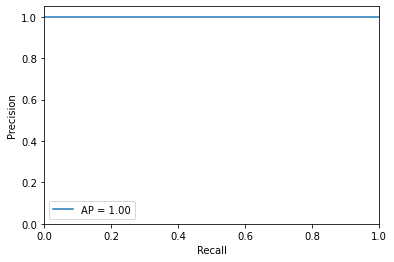

AP=1.00
precision=1.00, recall=0.69, f1=0.82
43 | 19 
 0 | 0
iou_threshold=0.1
------------------------------------------------------------------------------------


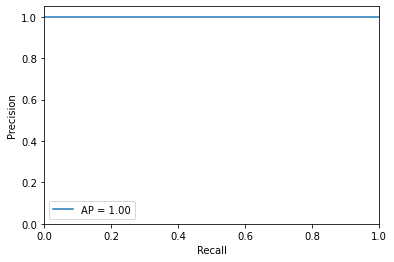

AP=1.00
precision=1.00, recall=0.55, f1=0.71
34 | 28 
 0 | 0
iou_threshold=0.2
------------------------------------------------------------------------------------


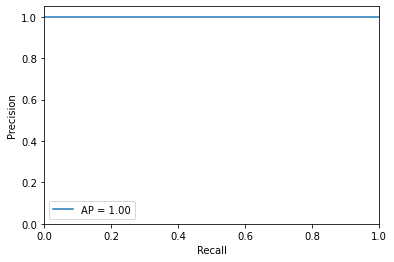

AP=1.00
precision=1.00, recall=0.45, f1=0.62
28 | 34 
 0 | 0
iou_threshold=0.30000000000000004
------------------------------------------------------------------------------------


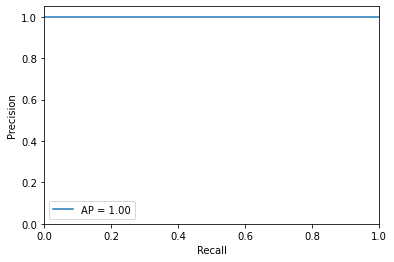

AP=1.00
precision=1.00, recall=0.31, f1=0.47
19 | 43 
 0 | 0
iou_threshold=0.4
------------------------------------------------------------------------------------


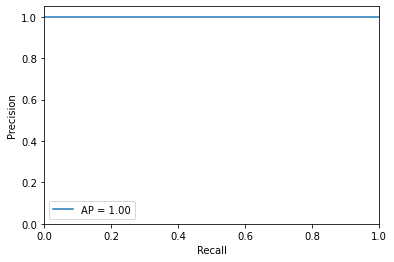

AP=1.00
precision=1.00, recall=0.15, f1=0.25
9 | 53 
 0 | 0
iou_threshold=0.5
------------------------------------------------------------------------------------


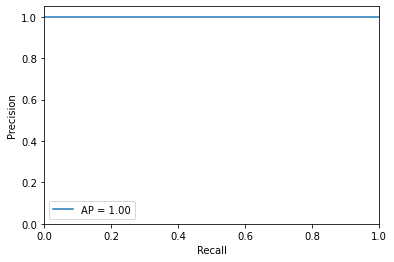

AP=1.00
precision=1.00, recall=0.05, f1=0.09
3 | 59 
 0 | 0
iou_threshold=0.6
------------------------------------------------------------------------------------


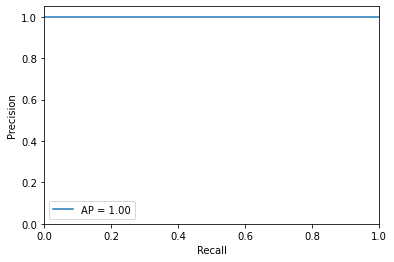

AP=1.00
precision=1.00, recall=0.03, f1=0.06
2 | 60 
 0 | 0
iou_threshold=0.7000000000000001
------------------------------------------------------------------------------------


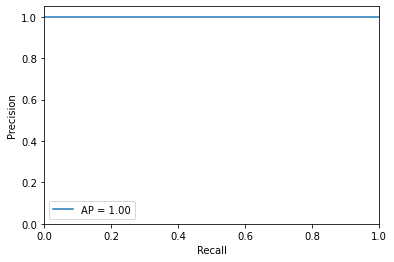

AP=1.00
precision=1.00, recall=0.02, f1=0.03
1 | 61 
 0 | 0
iou_threshold=0.8
------------------------------------------------------------------------------------


In [13]:
iou_thresholds = np.arange(0.1, 0.9, 0.1)
test_img_names = true_bbox.keys()
precisions, recalls, f1s = [], [], []
for iou_threshold in iou_thresholds:
    TP,FP,FN,TN = 0,0,0,0
    y_true   = []  # 0:無壺腹乳頭 1:有壺腹乳頭
    y_scores = []  # ciou分數
    for test_img_name in test_img_names:
        if true_bbox[test_img_name] != 'nan' and pred_bbox[test_img_name] != 'nan':
            ciou = calculate_ciou(true_bbox[test_img_name], pred_bbox[test_img_name])  # 找出真實box和預測box的iou
            
            if ciou>=iou_threshold:   # 如果>=iou，才是有預測到，TP會增加
                y_true.append(1)
                y_scores.append(ciou)
                TP += 1
            else:
                y_true.append(1)
                y_scores.append(0)
                FN += 1               # 如果<iou，FN也會增加
        elif true_bbox[test_img_name] != 'nan' and pred_bbox[test_img_name] == 'nan':
            y_true.append(1)
            y_scores.append(0)
            FN += 1
        elif true_bbox[test_img_name] == 'nan' and pred_bbox[test_img_name] != 'nan':
            y_true.append(0)
            y_scores.append(1)
            FP += 1
        else:
            y_true.append(0)
            y_scores.append(0)
            TN += 1

    
    plt_precision_recall_curve(y_true, y_scores)
    precision, recall, f1 = valid(TP, FN, FP, TN)
    print('iou_threshold={}'.format(iou_threshold))
    print("------------------------------------------------------------------------------------")
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

# 劃出圖

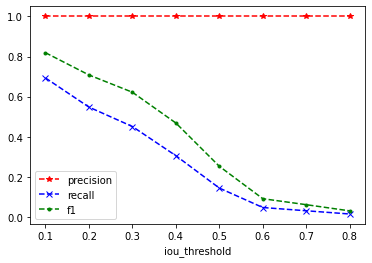

In [14]:
x  = iou_thresholds
y1 = precisions
y2 = recalls
y3 = f1s

plt.plot(x, y1, 'r--*')
plt.xlabel('iou_threshold')   
# plt.ylabel('accuracy')  
plt.plot(x, y2, 'b--x')     
plt.plot(x, y3, 'g--.')     
plt.legend(['precision','recall','f1'])
plt.show()